In [6]:
import torch
import torch.nn.functional as F
def loss_f(y_pred, y, data, **kwargs):
    count = y.count_nonzero()
    pos_weight = (len(y) - count) / count
    weight = data.x[:, 0].detach()
    return F.binary_cross_entropy_with_logits(y_pred, y, weight=weight, pos_weight=pos_weight)

In [7]:
import lib.rank_model as rankers
import lib.model as model_factory
from lib.model import train_classifier, print_results
rel(rankers,model_factory)
model, result, trainer = train_classifier(ds, model_name='InfoModel', epochs=40, task='timenode', loader_workers=0, loss=loss_f, lr=1e-4,
                                         edge_dim=0, batch_size=32)
print_results(result)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No pretrained found, training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | InfoModel | 13.7 K
------------------------------------
13.7 K    Trainable params
0         Non-trainable params
13.7 K    Total params
0.055     Total estimated model params size (MB)


E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
E:\Anaconda\envs\graph\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
Global seed set to 42
E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Train accuracy: 79.59%
Val accuracy:   92.59%
Test accuracy:  94.07%


In [ ]:
import torch
import math

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")  # Uncomment this to run on GPU

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Create random Tensors for weights. For a third order polynomial, we need
# 4 weights: y = a + b x + c x^2 + d x^3
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.randn((), device=device, dtype=dtype, requires_grad=True)
b = torch.randn((), device=device, dtype=dtype, requires_grad=True)
c = torch.randn((), device=device, dtype=dtype, requires_grad=True)
d = torch.randn((), device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y using operations on Tensors.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

In [55]:
from torch_geometric.data import Data, Batch
from torch_sparse import SparseTensor
d1 = Data(x=torch.tensor([1,2,3]), edge_index=torch.tensor([[0,2,0], [1,1,2]]), edge_attr=torch.tensor([2,2]), edge_current=SparseTensor(row=torch.tensor([1,1,0]), col=torch.tensor([2,0,2]), sparse_sizes=(3,3)))
d2 = Data(x=torch.tensor([4,5,3]), edge_index=torch.tensor([[0,0], [1,1]]), edge_attr=torch.tensor([2,2]), edge_current=SparseTensor(row=torch.tensor([2,1]), col=torch.tensor([0,0]), sparse_sizes=(3,3)))
b = Batch.from_data_list((d1,d2))

In [67]:
from torch_geometric.data import Data, Batch
from torch_sparse import SparseTensor
d1 = Data(x=torch.tensor([1,2,3]), edge_index=(torch.tensor([[0,2], [1,1]]), torch.tensor([[1,1,0], [2,0,2]])), edge_current=torch.tensor([[1,1,0], [2,0,2]]).T)
d2 = Data(x=torch.tensor([4,5,3]), edge_index=(torch.tensor([[0,0], [1,1]]), torch.tensor([[2,1], [0,0]])), edge_current=torch.tensor([[2,1], [0,0]]).T)
b = Batch.from_data_list((d1,d2))

In [68]:
b.edge_index

[tensor([[0, 2, 3, 3],
         [1, 1, 4, 4]]),
 tensor([[1, 1, 0, 5, 4],
         [2, 0, 2, 3, 3]])]

In [298]:
import copy
x = torch.zeros(1000, input_features, device=model.device)
edge_index = torch.zeros(2, 50, dtype=torch.long, device=model.device)
edge_attr = torch.zeros(50, 2, device=model.device)
batch_idx = torch.zeros(len(x), dtype=int, device=model.device)

from pytorch_model_summary import summary
s = summary(copy.deepcopy(model), x, edge_index, edge_attr, (edge_index, edge_attr), batch_idx, max_depth=2, print_summary=1, show_parent_layers=1)

-----------------------------------------------------------------------------------------------------------
                Parent Layers       Layer (type)               Output Shape         Param #     Tr. Param #
   EnsembleModel/RankingModel        InfoModel-1     [1000, 64], [1000, 64]           2,050           2,050
   EnsembleModel/RankingModel        InfoModel-2     [1000, 64], [1000, 64]          35,119          35,119
   EnsembleModel/RankingModel              MLP-3                 [1000, 64]          17,344          17,344
   EnsembleModel/RankingModel              MLP-4                  [1000, 1]           9,153           9,153
   EnsembleModel/RankingModel              MLP-5                     [1, 1]           9,153           9,153
   EnsembleModel/RankingModel        InfoModel-6     [1000, 64], [1000, 64]           2,050           2,050
   EnsembleModel/RankingModel        InfoModel-7     [1000, 64], [1000, 64]          35,119          35,119
   EnsembleModel/RankingMode


Running simulation with parameters:
netsize = 30, k = 2.8, dual = 0, model = seir
overlap = 0.8, uptake = 1.0, maintain_overlap = False
taut = 0, taur = 0, noncomp = 0, noncomp_dependtime = True

[(0.4, 0.5, 0.1), ()]
0.43010752688172044 0.5698924731182796
                                                                     
Running iteration 0, with eps = 0:
Iterations simulation progress:   0%|          | 0/1 [00:00<?, ?it/s]

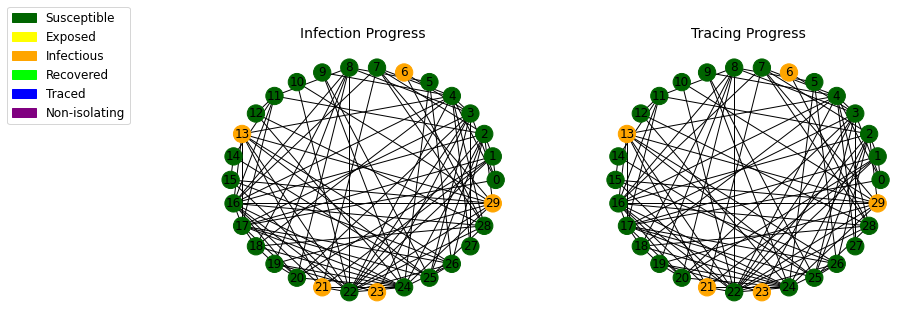

Final state:                                                         
Iterations simulation progress:   0%|          | 0/1 [00:00<?, ?it/s]

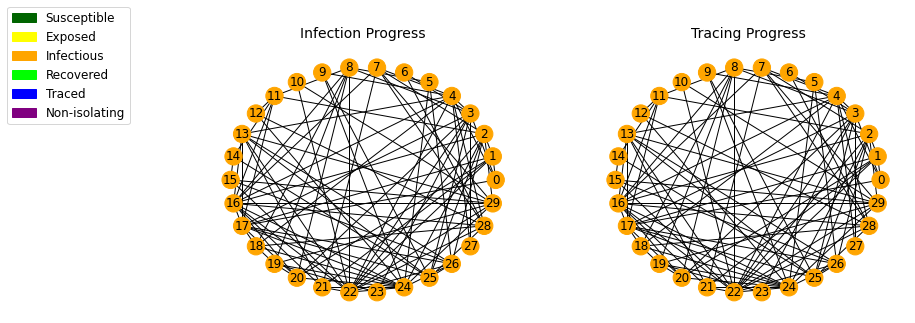

---> Result: 30 total infected over time. %healthy = 0.0             
Iterations simulation progress: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


In [13]:
import lib.run_tracing as run
import lib.tracing.network as net
import lib.tracing.utils as ut
ut.rel(net, run)
st, extra = run.run_mock(agent=None, control_after=5, control_after_inf=.05, control_initial_known=.25, control_gpu=0,
                                first_inf=5, presample=10000, pa=.2, taur=0, taut=0, update_after=1, edge_sample_size=[], reindex=False,
                                nettype='config:2.68,-4.44,11.18:3.2e-3,.36', netsize=30, k=2.8, p=.1, rem_orphans=False, use_weights=[(.4, .5, .1), ()],
                                seed=21, netseed=26, infseed=-1, model='seir', spontan=False, sampling_type='min', dual=0,
                                multip=0, nnets=1, niters=1, nevents=0, noncomp=0, noncomp_after=10000,
                                draw=1, draw_iter=0, animate=0, draw_fullname=True, draw_layout='circular',
                                summary_print=0, summary_splits=20, avg_without_earlystop=True)

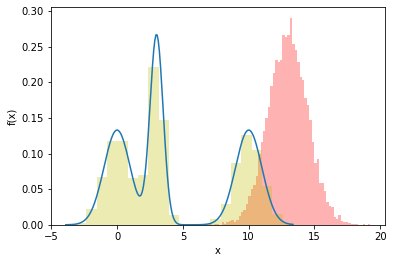

In [127]:
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt

# Set-up.
n = 10000
numpy.random.seed(0x5eed)
# Parameters of the mixture components
norm_params = np.array([[0, 1],
                        [10, 1],
                        [3, .5]])
n_components = norm_params.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(n_components, dtype=np.float64) / float(n_components)
# A stream of indices from which to choose the component
mixture_idx = numpy.random.choice(n_components, size=n, replace=True, p=weights)
# y is the mixture sample
y = numpy.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                   dtype=np.float64)

y_p = [sum([ss.norm.rvs(*param) for param in norm_params]) for i in range(n)]

# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(y.min(), y.max(), 200)
ys = np.zeros_like(xs)
for (l, s), w in zip(norm_params, weights):
    ys += ss.norm.pdf(xs, loc=l, scale=s) * w  

plt.plot(xs, ys)
plt.hist(y_p, density=True, alpha=.3, bins="fd", color='r')
plt.hist(y, density=True, alpha=.3, bins="fd", color='y')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [1]:
import copy
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_sched
import torch_geometric.nn as pyg_nn

import lib.run_tracing as run
import lib.tracing.multirun_engine as eng
import lib.tracing.utils as utils
import lib.tracing.network as network
import lib.tracing.stats as stat
import lib.tracing.simulation as sim
from lib.tracing.utils import rel
import lib.agent as agent
import lib.rank_model as rank
rel(utils, stat, sim, network, agent, eng, run)

def init_weights(m):
    """
    recursively initializes the weights of the model
    """
    # if isinstance(m, rank.EnsembleModel):
    #     nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    # for older versions of PYG which had a weight parameter directly within the MessagePassing class
    elif isinstance(m, pyg_nn.MessagePassing) and hasattr(m, 'weight'):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    # # some modules may not have a bias or they may use the name with a bool value to trigger other behavior
    if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
        m.bias.data.fill_(0.01)

# torch.manual_seed for instatiating parameters (only relevant if change_model!)
torch_seed = 15
# whether to load ckp parameters of the model or not
load = 0
# k-hops infection neighborhood to dynamically store as feature for each node
k_hops = 2
# static features to calculate for each node
static_measures = ('degree', 'eigenvector_centrality_numpy', 'rand:5',)
# global learning rate to use (0 is disabled) - this can be overwritten if change_model and NO loading of parameters from ckp
lr = 0
# init weights override
is_init_weights = 1
# ensemble number
n_models = 1

# whether to instantiate a new model (will be done automatically if 'model' not in globals)
change_model = bool(1) or 'model' not in globals()
# multiprocessing type
multip = 0

if change_model:
    try:
        model = model.model
    except (NameError, AttributeError):
        print('Instantiating new model.', end=' ')
        input_features = 4 + k_hops
        for measure in static_measures:
            try:
                input_features += int(measure.split(':')[1])
            except IndexError:
                input_features += 1
        rel(rank)
        model_class = rank.EnsembleModel if n_models > 1 else rank.RankingModel
        model = model_class(input_features, 1,
                              n_models=n_models,
                              combine='avg',
                              layer_name='GINE',
                              # layer_kwargs=dict(num_layers=5),
                              num_layers=4,
                              norm_layer='LayerNorm',
                              use_edge_attr=1, # whether to use edge_attr or not in InfoModel
                              edge_dim=2, # edge_attr has 2 dims that need to be linearly transformed
                              edge_attr_scaling=True, # needed for many GNN models with edge_attr
                              last_fully_adjacent=1,
                              add_self_loops=1,
                              diff_add_self_loops=1,
                              diff_layer_name='GAT2',
                              diff_layer_kwargs=dict(edge_dim=2, add_self_loops=0, heads=1, concat=False),
                              diff_use_edge_attr=1, # whether to use the edge_weights or not (i.e. edge_attr at index 0)
                              nonlin='ReLU',
                              agg='cat',
                              reduce_h='std',
                              dropout=0,
                              dropout_head=0,
                              layers_head=1,
                              linear_head=1,
                              nonlin_head='ReLU',
                              state_score_method='max',
                              last_incl_gnn_outs=0,
                              torch_seed=torch_seed,
                              reset_h_seed=-1,
                              deterministic=True,
                             )
        if load:
            print('Loading from pretrain...', end=' ')
            model.load_state_dict(torch.load('saved/ranking_0.pt'))
        else:
            if is_init_weights:
                print('Manually init weights...', end=' ')
                model.apply(init_weights)
            lr = 1e-4
        
    if multip:
        model.share_memory()
else:
    # must make sure previous iteration's h_prev and gradietns are never distributed
    try:
        model.h_prev = None
        model.zero_grad(set_to_none=True)
    except:
        pass
    if multip and model.device.type != 'cpu':
        print('Moving model to CPU due to multiprocessing...')
        model = model.cpu()

is_learning = lr > 0
online = 1
predef = 1
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=.1, lr=lr)#,momentum=.9) if predef else 'Adam'\n",
schedulers = [lr_sched.StepLR(optimizer, 100, .3, verbose=0), lr_sched.ReduceLROnPlateau(optimizer, 'min', .5, patience=25, verbose=1)] \
                if predef else ['StepLR',]
print(f'{lr=}...\nLearning with {online=}: {is_learning}')
ag = dict(
    typ='sl',
    rl_sampler='softmax',
    # gamma, lambda, reward_scale, actor_loss, clip_ratio, value_coeff, entropy_coeff, ce_coeff, eligibility, target_update
    rl_args=(.99, .97, 1, 'ppo', -0.2, 0.5, 0, 0, 1, 5),
    ranking_model=model,
    target_model=copy.deepcopy(model) if is_learning and online else None,
    debug_print=-1,
    index_weight=-1,
    pos_weight=False,
    edge_forget_after=1,
    mark_delay_same_edges=False,
    half_cpu=1,
    lr=lr,
    online=online,
    epochs=2,
    batch_size=10,
    grad_clip=.5,
    optimizer=optimizer,
    optimizer_kwargs=dict(weight_decay=.1),
    schedulers=schedulers,
    schedulers_args=((50, .2),),
    measure='degree',
    record_edges=True,
    static_measures=static_measures, 
    n_test=2,
    n_trace=0,
    tester=True,
    tracer=False,
    k_hops=k_hops,
    seed=12,
    dist_over_sample=1, # IF distrib is over the sample (T) OR all the nodes (F); when True, only logp = y_pred[nodes] is possible
    logp_from_score=1, # IF logp = y_pred[nodes] (T) OR logp = pi.log_prob(nodes) (F)
    logpold_from_score=1, # IF logp_old = y_pred[nodes] (T) OR logp_old = pi.log_prob(nodes) (F)
    debug=0, # !!! VERY IMPORTANT TO SET TO 0 WHEN MULTIPROCESSING IS EXPECTED FROM THE SAME MODEL
    pred_vars=(2,1),
)

torch.autograd.set_detect_anomaly(False)

n_episodes = 5 if is_learning else 1 #n_models+1
eps_start = .5
eps_decay = .99
eps = [round(eps_start * eps_decay**i, 5) for i in range(n_episodes)]
error_del_model = 0
# extra can hold information such as the networks and shared values among processes
extra = [0]

try:
    st, extra = run.run_mock(agent=ag, control_after=5, control_after_inf=.05, control_initial_known=.25, control_gpu=0,
                                first_inf=5, presample=10000, pa=.2, taur=0, taut=eps, update_after=1, edge_sample_size=[], reindex=False,
                                nettype='barabasi:5:1', netsize=1000, k=2.8, p=.1, rem_orphans=False, use_weights=True, dual=0,
                                seed=21, netseed=26, infseed=-1, model='seir', spontan=False, sampling_type='min',
                                multip=0, nnets=1, niters=1, nevents=0, noncomp=0, noncomp_after=10000,
                                draw=0, draw_iter=0, animate=0, draw_fullname=True, draw_layout='circular',
                                summary_print=0, summary_splits=20, avg_without_earlystop=True)
    # here the key for inspecting results is either 'res' (For one episode) or the latest epsilon (For multiple episodes)
    key = 'res' if 'res' in st else eps[-1 if is_learning else 0]
    print('Total infected: ', st[key]['average-overall-infected']['mean'])
    print('Max infected: ', st[key]['average-max-infected']['mean'])
    print('%healthy: ', st[key]['average-%healthy']['mean'], '±', st[key]['average-%healthy']['std'])
except (Exception, BaseException) as e:
    raise e
finally:
    if error_del_model:
        print('Freeing memory...')
        del model, ag, extra[0] # first element of extra is a shared object which may be arbitrarily large
        torch.cuda.empty_cache()
        !nvidia-smi

Instantiating new model. Manually init weights... lr=0.0001...
Learning with online=1: True
                                                                     
Running iteration 0 during episode 0, with eps = 0.5:
---> Result: 854 total infected over time. %healthy = 0.146          
Iterations simulation progress: 100%|██████████| 1/1 [00:06<00:00,  6.91s/it]
                                                                     
Running iteration 0 during episode 1, with eps = 0.495:
---> Result: 822 total infected over time. %healthy = 0.178          
Iterations simulation progress: 100%|██████████| 1/1 [00:05<00:00,  5.96s/it]
                                                                     
Running iteration 0 during episode 2, with eps = 0.49005:
---> Result: 842 total infected over time. %healthy = 0.158          
Iterations simulation progress: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]
                                                                     
Running iteratio

KeyboardInterrupt: 

In [452]:
model.load_state_dict(torch.load('saved/ckp/on-over-sample.pt'))

<All keys matched successfully>

In [443]:
torch.save(model.state_dict(), 'saved/ckp/off-over-sample.pt')

In [448]:
off_all = [f"{st[k]['average-%healthy']['mean']} ± {st[k]['average-%healthy']['std']}" for k in st if k != 'args']
off_all

['0.49 ± 0.05', '0.44 ± 0.05', '0.47 ± 0.06', '0.5 ± 0.05']

In [445]:
off = [f"{st[k]['average-%healthy']['mean']} ± {st[k]['average-%healthy']['std']}" for k in st if k != 'args']
off

['0.51 ± 0.04', '0.51 ± 0.04', '0.51 ± 0.04', '0.49 ± 0.03']

In [454]:
on = [f"{st[k]['average-%healthy']['mean']} ± {st[k]['average-%healthy']['std']}" for k in st if k != 'args']
on

['0.51 ± 0.04', '0.5 ± 0.04', '0.51 ± 0.04', '0.51 ± 0.05']

In [20]:
on = [f"{st[k]['average-%healthy']['mean']} ± {st[k]['average-%healthy']['std']}" for k in st if k != 'args']
on

['0.51 ± 0.03', '0.5 ± 0.03', '0.51 ± 0.04', '0.5 ± 0.04']

In [451]:
on_all = [f"{st[k]['average-%healthy']['mean']} ± {st[k]['average-%healthy']['std']}" for k in st if k != 'args']
on_all

['0.49 ± 0.04', '0.48 ± 0.04', '0.47 ± 0.06', '0.47 ± 0.04']

In [22]:
cent = [f"{st[k]['average-%healthy']['mean']} ± {st[k]['average-%healthy']['std']}" for k in st if k != 'args']
cent

['0.47 ± 0.04', '0.47 ± 0.04', '0.47 ± 0.04', '0.47 ± 0.04']

In [78]:
import pandas as pd
df = pd.DataFrame(data={'No Train': ['0.42 ± 0.04', '0.43 ± 0.04', '0.19 ± 0.04', '0.35 ± 0.04'], 'Degree': ['0.47 ± 0.04', '0.47 ± 0.04', '0.47 ± 0.04', '0.47 ± 0.04'], 
                        'SL(10)': ['0.44 ± 0.04', '0.24 ± 0.04', '0.26 ± 0.08', '0.45 ± 0.03'], 'RL(10,offline)': ['0.49 ± 0.04', '0.38 ± 0.05', '0.19 ± 0.04', '0.48 ± 0.04'],
                        'RL(10,online)': ['0.51 ± 0.03', '0.5 ± 0.03', '0.51 ± 0.04', '0.5 ± 0.04']},
                 index=['Average', 'Model 1', 'Model 2', 'Model 3'])
s = df.style.set_properties(**{'font-size': '13pt'}) \
            .set_table_styles([ dict(selector='th', props=[('font-size', '150%')]) ]) \
            .applymap(lambda x: 'background-color: %s' % ('blue' if float(x.split(' ')[0])>= 0.5 else None))
s

,No Train,Degree,SL(10),"RL(10,offline)","RL(10,online)"
Average,0.42 ± 0.04,0.47 ± 0.04,0.44 ± 0.04,0.49 ± 0.04,0.51 ± 0.03
Model 1,0.43 ± 0.04,0.47 ± 0.04,0.24 ± 0.04,0.38 ± 0.05,0.5 ± 0.03
Model 2,0.19 ± 0.04,0.47 ± 0.04,0.26 ± 0.08,0.19 ± 0.04,0.51 ± 0.04
Model 3,0.35 ± 0.04,0.47 ± 0.04,0.45 ± 0.03,0.48 ± 0.04,0.5 ± 0.04


In [3]:
360/ 1000

0.36

In [19]:
import pandas as pd
df = pd.DataFrame(data={'Random': ['0.13 ± 0.03', '0.16 ± 0.02'],
                        'Degree': ['0.47 ± 0.04', '0.54 ± 0.04'],
                        'Eigenvector': ['0.36 + 0.03', '0.36 ± 0.02'],
                        'Online SL': ['0.44 ± 0.04', '0.53 ± 0.03'],
                        'Offline PPO': ['0.51 ± 0.04', '0.57 ± 0.04'],
                        'Online PPO': ['0.51 ± 0.04', '0.57 ± 0.03'],
                        
                        },
                 index=['Static network', 'Dynamic network'])
s = df.transpose().style.set_properties(**{'font-size': '13pt', 'text-align':'center'}) \
            .set_table_styles([ dict(selector='th', props=[('font-size', '150%')]) ]) \
            .applymap(lambda x: 'font-weight: %s' % ('bold' if float(x.split(' ')[0])in (.51, .57) else None))
s

,Static network,Dynamic network
Random,0.13 ± 0.03,0.16 ± 0.02
Degree,0.47 ± 0.04,0.54 ± 0.04
Eigenvector,0.36 + 0.03,0.36 ± 0.02
Online SL,0.44 ± 0.04,0.53 ± 0.03
Offline PPO,0.51 ± 0.04,0.57 ± 0.04
Online PPO,0.51 ± 0.04,0.57 ± 0.03


In [ ]:
import pandas as pd
df = pd.DataFrame(data={'No-train': ['0.42 ± 0.04', '0.43 ± 0.04', '0.19 ± 0.04', '0.35 ± 0.04'], 'Degree-centrality': ['0.47 ± 0.04', '0.47 ± 0.04', '0.47 ± 0.04', '0.47 ± 0.04'], 
                        'RL-online-sample': ['0.51 ± 0.04', '0.5 ± 0.04', '0.51 ± 0.04', '0.51 ± 0.05'], 'RL-offline-sample': ['0.51 ± 0.04', '0.51 ± 0.04', '0.51 ± 0.04', '0.49 ± 0.03'],
                        },
                 index=['Average', 'Model 1', 'Model 2', 'Model 3'])
s = df.style.set_properties(**{'font-size': '13pt', 'text-align':'center'}) \
            .set_table_styles([ dict(selector='th', props=[('font-size', '150%')]) ]) \
            .applymap(lambda x: 'font-weight: %s' % ('bold' if float(x.split(' ')[0])>= 0.51 else None))
s

In [20]:
s.to_excel()

TypeError: to_excel() missing 1 required positional argument: 'excel_writer'

In [21]:
with open('fig/df.csv', 'w', encoding='utf-8') as f:
    s.to_excel(f)

ModuleNotFoundError: No module named 'openpyxl'

In [5]:
import copy
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn

import lib.run_tracing as run
import lib.tracing.multirun_engine as eng
import lib.tracing.utils as utils
import lib.tracing.network as network
import lib.tracing.stats as stat
import lib.tracing.simulation as sim
from lib.tracing.utils import rel
import lib.agent as agent
import lib.rank_model as rank
rel(utils, stat, sim, network, agent, eng, run)

def init_weights(m):
    """
    recursively initializes the weights of the model
    """
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    # for older versions of PYG which had a weight parameter directly within the MessagePassing class
    elif isinstance(m, pyg_nn.MessagePassing) and hasattr(m, 'weight'):
        nn.init.kaiming_uniform_(m.weight)
    # # some modules may not have a bias or they may use the name with a bool value to trigger other behavior
    if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
        m.bias.data.fill_(0.01)

# whether to instantiate a new model (will be done automatically if 'model' not in globals)
change_model = bool(1) or 'model' not in globals()
# torch.manual_seed for instatiating parameters (only relevant if change_model!)
torch_seed = 15
# whether to load ckp parameters of the model or not
load = 0
# k-hops infection neighborhood to dynamically store as feature for each node
k_hops = 2
# static features to calculate for each node
static_measures = ('degree', 'eigenvector', 'rand:5',)
# global learning rate to use (0 is disabled) - this can be overwritten if change_model and NO loading of parameters from ckp
lr = 0
# multiprocessing type
multip = 0
# init weights override
is_init_weights = 1
# ensemble number
n_models = 1

        
if change_model:
    try:
        model = model.model
    except (NameError, AttributeError):
        print('Instantiating new model.', end=' ')
        input_features = 4 + k_hops
        for measure in static_measures:
            try:
                input_features += int(measure.split(':')[1])
            except IndexError:
                input_features += 1
        rel(rank)
        model_class = rank.EnsembleModel if n_models > 1 else rank.RankingModel
        model = model_class(input_features, 1,
                                  n_models=n_models,
                                  layer_name='GINE',
                                  # layer_kwargs=dict(num_layers=5),
                                  num_layers=4,
                                  norm_layer='LayerNorm',
                                  use_edge_attr=1, # whether to use edge_attr or not in InfoModel
                                  edge_dim=2, # edge_attr has 2 dims that need to be linearly transformed
                                  edge_attr_scaling=True, # needed for many GNN models with edge_attr
                                  last_fully_adjacent=1,
                                  add_self_loops=1,
                                  diff_add_self_loops=1,
                                  diff_layer_name='GAT2',
                                  diff_layer_kwargs=dict(edge_dim=2, add_self_loops=0, heads=1, concat=False),
                                  diff_use_edge_attr=1, # whether to use the edge_weights or not (i.e. edge_attr at index 0)
                                  nonlin='ReLU',
                                  agg='cat',
                                  reduce_h='std',
                                  dropout=0,
                                  dropout_head=0,
                                  layers_head=1,
                                  linear_head=1,
                                  nonlin_head='ReLU',
                                  state_score_method='max',
                                  last_incl_gnn_outs=0,
                                  torch_seed=torch_seed,
                                  reset_h_seed=-1,
                                  deterministic=1,
                                 )
        if load:
            print('Loading from pretrain...', end=' ')
            model.load_state_dict(torch.load('saved/ranking_0.pt'))
        else:
            if is_init_weights:
                print('Manually init weights...', end=' ')
                model.apply(init_weights)
            lr = 1e-4
        
    if multip:
        model.share_memory()


print(f'{lr=}')
optimizer = torch.optim.Adam(model.parameters(), weight_decay=.1)
online = 1
ag = dict(
    typ='sl',
    rl_sampler='softmax',
    # gamma, lambda, reward_scale, actor_loss, clip_ratio, value_coeff, entropy_coeff, ce_coeff, eligibility, target_update
    rl_args=(.99, .97, 1, 'ppo', -0.2, 0.5, 0, 0, 1, 5),
    ranking_model=model,
    target_model=copy.deepcopy(model) if online else None,
    debug_print=-1,
    index_weight=-1,
    pos_weight=False,
    mark_delay_same_edges=False,
    lr=lr,
    online=online,
    epochs=5,
    batch_size=10,
    grad_clip=.5,
    optimizer=optimizer,
    optimizer_kwargs=dict(weight_decay=.1),
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 50, 0.2),
    measure='closeness',
    record_edges=True,
    static_measures=static_measures, 
    n_test=2,
    n_trace=0,
    tester=True,
    tracer=False,
    k_hops=k_hops,
    seed=12,
    dist_over_sample=1, # IF distrib is over the sample (T) OR all the nodes (F); when True, only logp = y_pred[nodes] is possible
    logp_from_score=1, # IF logp = y_pred[nodes] (T) OR logp = pi.log_prob(nodes) (F)
    logpold_from_score=1 # IF logp_old = y_pred[nodes] (T) OR logp_old = pi.log_prob(nodes) (F)
)


n_episodes = 50
eps_start = .5
eps_decay = .99
eps = [round(eps_start * eps_decay**i, 5) for i in range(n_episodes)]
error_del_model = 1

torch.autograd.set_detect_anomaly(False)
st = extra = False
try:
    st, extra = run.run_mock(agent=ag, control_after=5, control_after_inf=.05, control_initial_known=.25, control_gpu=1,
                                first_inf=5, presample=10000, pa=.2, taur=0, taut=eps, update_after=1, edge_sample_size=[],
                                nettype='barabasi:5:1', netsize=1000, k=2.8, p=.1, rem_orphans=False, use_weights=True, dual=0,
                                seed=21, netseed=25, infseed=-1, model='seir', spontan=False, sampling_type='min', reindex=False,
                                multip=0, nnets=1, niters=1, nevents=0, noncomp=0, noncomp_after=10000,
                                draw=0, draw_iter=0, draw_fullname=True, draw_layout='graphviz',
                                summary_print=0, summary_splits=20, avg_without_earlystop=True)
    # here the key for inspecting results is either 'res' (For one episode) or the latest epsilon (For multiple episodes)
    key = 'res' if 'res' in st else eps[-1]
    print('Total infected: ', st[key]['average-overall-infected']['mean'])
    print('Max infected: ', st[key]['average-max-infected']['mean'])
    print('%healthy: ', st[key]['average-%healthy']['mean'], '±', st[key]['average-%healthy']['std'])
except (Exception, BaseException) as e:
    if error_del_model:
        del model, ag, st, extra
        torch.cuda.empty_cache()
        !nvidia-smi
    raise e

Instantiating new model. Manually init weights... lr=0.0001
                                                                                                                       
Running iteration 0 with eps = 0.5:
---> Result: 700 total infected over time. %healthy = 0.3                                                              
Iterations simulation progress: 100%|████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/it]
                                                                                                                       
Running iteration 0 with eps = 0.495:
---> Result: 642 total infected over time. %healthy = 0.358                                                            
Iterations simulation progress: 100%|████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.99s/it]
                                                                                                                       
Running iteration 0 with e

KeyboardInterrupt: 

In [31]:
import copy
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn

import lib.run_tracing as run
import lib.tracing.multirun_engine as eng
import lib.tracing.utils as utils
import lib.tracing.network as network
import lib.tracing.stats as stat
import lib.tracing.simulation as sim
from lib.tracing.utils import rel
import lib.agent as agent
import lib.rank_model as rank
rel(utils, stat, sim, network, agent, eng, run)

def init_weights(m):
    """
    recursively initializes the weights of the model
    """
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    # for older versions of PYG which had a weight parameter directly within the MessagePassing class
    elif isinstance(m, pyg_nn.MessagePassing) and hasattr(m, 'weight'):
        nn.init.kaiming_uniform_(m.weight)
    # # some modules may not have a bias or they may use the name with a bool value to trigger other behavior
    if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
        m.bias.data.fill_(0.01)

# whether to instantiate a new model (will be done automatically if 'model' not in globals)
change_model = bool(1) or 'model' not in globals()
# torch.manual_seed for instatiating parameters (only relevant if change_model!)
torch_seed = 15
# whether to load ckp parameters of the model or not
load = 0
# k-hops infection neighborhood to dynamically store as feature for each node
k_hops = 2
# static features to calculate for each node
static_measures = ('degree', 'eigenvector', 'rand:5',)
# global learning rate to use (0 is disabled) - this can be overwritten if change_model and NO loading of parameters from ckp
lr = 0
# multiprocessing type
multip = 0
# init weights override
is_init_weights = 1
# ensemble number
n_models = 1

        
if change_model:
    try:
        model = model.model
    except (NameError, AttributeError):
        print('Instantiating new model.', end=' ')
        input_features = 4 + k_hops
        for measure in static_measures:
            try:
                input_features += int(measure.split(':')[1])
            except IndexError:
                input_features += 1
        rel(rank)
        model_class = rank.EnsembleModel if n_models > 1 else rank.RankingModel
        model = model_class(input_features, 1,
                                  n_models=n_models,
                                  layer_name='GINE',
                                  # layer_kwargs=dict(num_layers=5),
                                  num_layers=4,
                                  norm_layer='LayerNorm',
                                  use_edge_attr=1, # whether to use edge_attr or not in InfoModel
                                  edge_dim=2, # edge_attr has 2 dims that need to be linearly transformed
                                  edge_attr_scaling=True, # needed for many GNN models with edge_attr
                                  last_fully_adjacent=1,
                                  add_self_loops=1,
                                  diff_add_self_loops=1,
                                  diff_layer_name='GAT2',
                                  diff_layer_kwargs=dict(edge_dim=2, add_self_loops=0, heads=1, concat=False),
                                  diff_use_edge_attr=1, # whether to use the edge_weights or not (i.e. edge_attr at index 0)
                                  nonlin='ReLU',
                                  agg='cat',
                                  reduce_h='std',
                                  dropout=0,
                                  dropout_head=0,
                                  layers_head=1,
                                  linear_head=1,
                                  nonlin_head='ReLU',
                                  state_score_method='max',
                                  last_incl_gnn_outs=0,
                                  torch_seed=torch_seed,
                                  reset_h_seed=-1,
                                  deterministic=1,
                                 )
        if load:
            print('Loading from pretrain...', end=' ')
            model.load_state_dict(torch.load('saved/ranking_0.pt'))
        else:
            if is_init_weights:
                print('Manually init weights...', end=' ')
                model.apply(init_weights)
            lr = 1e-4
        
    if multip:
        model.share_memory()


print(f'{lr=}')
optimizer = torch.optim.Adam(model.parameters(), weight_decay=.1)
online = 1
ag = dict(
    typ='sl',
    rl_sampler='softmax',
    # gamma, lambda, reward_scale, actor_loss, clip_ratio, value_coeff, entropy_coeff, ce_coeff, eligibility, target_update
    rl_args=(.99, .97, 1, 'ppo', -0.2, 0.5, 0, 0, 1, 5),
    ranking_model=model,
    target_model=copy.deepcopy(model) if online else None,
    debug_print=-1,
    index_weight=-1,
    pos_weight=False,
    mark_delay_same_edges=False,
    gpu=1,
    lr=lr,
    online=online,
    epochs=5,
    batch_size=10,
    grad_clip=.5,
    optimizer=optimizer,
    optimizer_kwargs=dict(weight_decay=.1),
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 50, 0.2),
    measure='closeness',
    record_edges=True,
    static_measures=static_measures, 
    n_test=2,
    n_trace=0,
    tester=True,
    tracer=False,
    k_hops=k_hops,
    seed=12,
    dist_over_sample=1, # IF distrib is over the sample (T) OR all the nodes (F); when True, only logp = y_pred[nodes] is possible
    logp_from_score=1, # IF logp = y_pred[nodes] (T) OR logp = pi.log_prob(nodes) (F)
    logpold_from_score=1 # IF logp_old = y_pred[nodes] (T) OR logp_old = pi.log_prob(nodes) (F)
)


n_episodes = 50
eps_start = .5
eps_decay = .99
eps = [round(eps_start * eps_decay**i, 5) for i in range(n_episodes)]
error_del_model = 1

torch.autograd.set_detect_anomaly(False)
st = extra = False
try:
    st, extra = run.run_mock(agent=ag, control_after=5, control_after_inf=.05, control_initial_known=.25,
                                first_inf=5, presample=10000, pa=.2, taur=0, taut=eps,
                                nettype='barabasi:5:1', netsize=1000, k=2.8, p=.1, rem_orphans=False, use_weights=True, dual=0,
                                seed=21, netseed=25, infseed=-1, model='seir', spontan=False, sampling_type='min', update_after=1, reindex=False,
                                multip=0, nnets=1, niters=1, nevents=0, noncomp=0, noncomp_after=10000,
                                draw=0, draw_iter=0, draw_fullname=True, draw_layout='graphviz',
                                summary_print=0, summary_splits=20, avg_without_earlystop=True)
    # here the key for inspecting results is either 'res' (For one episode) or the latest epsilon (For multiple episodes)
    key = 'res' if 'res' in st else eps[-1]
    print('Total infected: ', st[key]['average-overall-infected']['mean'])
    print('Max infected: ', st[key]['average-max-infected']['mean'])
    print('%healthy: ', st[key]['average-%healthy']['mean'], '±', st[key]['average-%healthy']['std'])
except (Exception, BaseException) as e:
    if error_del_model:
        del model, ag, st, extra
        torch.cuda.empty_cache()
        !nvidia-smi
    raise e

Instantiating new model. Manually init weights... lr=0.0001
                                                                                                                       
Running iteration 0 with eps = 0.5:
---> Result: 700 total infected over time. %healthy = 0.3                                                              
Iterations simulation progress: 100%|████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/it]
                                                                                                                       
Running iteration 0 with eps = 0.495:
---> Result: 642 total infected over time. %healthy = 0.358                                                            
Iterations simulation progress: 100%|████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.92s/it]
                                                                                                                       
Running iteration 0 with e

In [ ]:
import copy
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn

import lib.run_tracing as run
import lib.tracing.multirun_engine as eng
import lib.tracing.utils as utils
import lib.tracing.network as network
import lib.tracing.stats as stat
import lib.tracing.simulation as sim
from lib.tracing.utils import rel
import lib.agent as agent
import lib.rank_model as rank
rel(utils, stat, sim, network, agent, eng, run)

def init_weights(m):
    """
    recursively initializes the weights of the model
    """
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    # for older versions of PYG which had a weight parameter directly within the MessagePassing class
    elif isinstance(m, pyg_nn.MessagePassing) and hasattr(m, 'weight'):
        nn.init.xavier_uniform_(m.weight)
    # some modules may not have a bias or they may use the name with a bool value to trigger other behavior
    if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
        m.bias.data.fill_(0.01)

# whether to instantiate a new model (will be done automatically if 'model' not in globals)
change_model = bool(1) or 'model' not in globals()
# torch.manual_seed for instatiating parameters (only relevant if change_model!)
torch_seed = 13
# whether to load ckp parameters of the model or not
load = 0
# k-hops infection neighborhood to dynamically store as feature for each node
k_hops = 2
# static features to calculate for each node
static_measures = ('degree', 'eigenvector', 'rand:3')
# global learning rate to use (0 is disabled) - this can be overwritten if change_model and NO loading of parameters from ckp
lr = 0
# multiprocessing type
multip = 0
# init weights override
is_init_weights = 1

        
if change_model:
    try:
        model = model.model
    except (NameError, AttributeError):
        print('Instantiating new model.', end=' ')
        input_features = 4 + k_hops
        for measure in static_measures:
            try:
                input_features += int(measure.split(':')[1])
            except IndexError:
                input_features += 1
        rel(rank)
        model = rank.RankingModel(input_features, 1,
                                  layer_name='GINE',
                                  # layer_kwargs=dict(num_layers=5),
                                  num_layers=4,
                                  norm_layer='LayerNorm',
                                  use_edge_attr=1, # whether to use edge_attr or not in InfoModel
                                  edge_dim=2, # edge_attr has 2 dims that need to be linearly transformed
                                  edge_attr_scaling=True, # needed for many GNN models with edge_attr
                                  last_fully_adjacent=1,
                                  add_self_loops=0,
                                  diff_layer_name='GAT2',
                                  diff_layer_kwargs=dict(edge_dim=2, add_self_loops=1, heads=1, concat=False),
                                  diff_use_edge_attr=1, # whether to use the edge_weights or not (i.e. edge_attr at index 0)
                                  nonlin='ReLU',
                                  agg='cat',
                                  reduce_h='mean-std',
                                  dropout=0,
                                  dropout_head=0,
                                  layers_head=1,
                                  linear_head=1,
                                  nonlin_head='ReLU',
                                  state_score_method='max',
                                  last_incl_gnn_outs=0,
                                  torch_seed=torch_seed,
                                  reset_h_seed=-1,
                                  deterministic=0
                                 )
        if load:
            print('Loading from pretrain...', end=' ')
            model.load_state_dict(torch.load('saved/ranking_0.pt'))
        else:
            if is_init_weights:
                print('Manually init weights...', end=' ')
                model.apply(init_weights)
            lr = 1e-3
        
    if multip:
        model.share_memory()


print(f'{lr=}')
optimizer = torch.optim.Adam(model.parameters(), weight_decay=.1)
online = 1
ag = dict(
    typ='sl',
    rl_sampler='softmax',
    # gamma, lambda, reward_scale, clip_ratio, value_coeff, entropy_coeff, ce_coeff, eligibility, target_update
    rl_args=(.99, .97, 1, -0.2, 0.5, 0.01, 0, 1, 5),
    ranking_model=model,
    target_model=copy.deepcopy(model) if online else None,
    debug_print=-1,
    index_weight=-1,
    pos_weight=False,
    mark_delay_same_edges=False,
    gpu=1,
    lr=lr,
    online=online,
    batch_size=5,
    grad_clip=.5,
    optimizer=optimizer,
    optimizer_kwargs=dict(weight_decay=.1),
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 100, 0.1),
    measure='degree',
    record_edges=True,
    static_measures=static_measures, 
    n_test=2,
    n_trace=0,
    tester=True,
    tracer=False,
    k_hops=k_hops,
    seed=12,
)


n_episodes = 50
eps_start = .5
eps_decay = .99
eps = [round(eps_start * eps_decay**i, 5) for i in range(n_episodes)]
error_del_model = 1

torch.autograd.set_detect_anomaly(False)
st = extra = False
try:
    st, extra = run.run_mock(agent=ag, control_after=5, control_after_inf=.05, control_initial_known=.25,
                                first_inf=5, presample=10000, pa=.2, taut=eps,
                                nettype='barabasi:5:1', netsize=1000, k=2.8, p=.1, rem_orphans=False, use_weights=True, dual=0,
                                seed=21, netseed=25, infseed=-1, model='seir', spontan=False, sampling_type='min', update_after=1, reindex=False,
                                multip=0, nnets=1, niters=1, nevents=0, noncomp=0, noncomp_after=10000,
                                draw=0, draw_iter=0, draw_fullname=True, draw_layout='graphviz',
                                summary_print=0, summary_splits=20, avg_without_earlystop=True)
    # here the key for inspecting results is either 'res' (For one episode) or the latest epsilon (For multiple episodes)
    key = 'res' if 'res' in st else eps[-1]
    print('Total infected: ', st[key]['average-overall-infected']['mean'])
    print('Max infected: ', st[key]['average-max-infected']['mean'])
    print('%healthy: ', st[key]['average-%healthy']['mean'], '±', st[key]['average-%healthy']['std'])
except (Exception, BaseException) as e:
    if error_del_model:
        del model, ag, st, extra
        torch.cuda.empty_cache()
        !nvidia-smi
    raise e

In [ ]:
import copy
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn

import lib.run_tracing as run
import lib.tracing.multirun_engine as eng
import lib.tracing.utils as utils
import lib.tracing.network as network
import lib.tracing.stats as stat
import lib.tracing.simulation as sim
from lib.tracing.utils import rel
import lib.agent as agent
import lib.rank_model as rank
rel(utils, stat, sim, network, agent, eng, run)

def init_weights(m):
    """
    recursively initializes the weights of the model
    """
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    # for older versions of PYG which had a weight parameter directly within the MessagePassing class
    elif isinstance(m, pyg_nn.MessagePassing) and hasattr(m, 'weight'):
        nn.init.xavier_uniform_(m.weight)
    # some modules may not have a bias or they may use the name with a bool value to trigger other behavior
    if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
        m.bias.data.fill_(0.01)

# whether to instantiate a new model (will be done automatically if 'model' not in globals)
change_model = bool(1) or 'model' not in globals()
# torch.manual_seed for instatiating parameters (only relevant if change_model!)
torch_seed = 13
# whether to load ckp parameters of the model or not
load = 0
# k-hops infection neighborhood to dynamically store as feature for each node
k_hops = 2
# static features to calculate for each node
static_measures = ('degree', 'eigenvector', 'rand:3')
# global learning rate to use (0 is disabled) - this can be overwritten if change_model and NO loading of parameters from ckp
lr = 0
# multiprocessing type
multip = 0
# init weights override
is_init_weights = 1

        
if change_model:
    try:
        model = model.model
    except (NameError, AttributeError):
        print('Instantiating new model.', end=' ')
        input_features = 4 + k_hops
        for measure in static_measures:
            try:
                input_features += int(measure.split(':')[1])
            except IndexError:
                input_features += 1
        rel(rank)
        model = rank.RankingModel(input_features, 1,
                                  layer_name='GINE',
                                  # layer_kwargs=dict(num_layers=5),
                                  num_layers=4,
                                  norm_layer='LayerNorm',
                                  use_edge_attr=1, # whether to use edge_attr or not in InfoModel
                                  edge_dim=2, # edge_attr has 2 dims that need to be linearly transformed
                                  edge_attr_scaling=True, # needed for many GNN models with edge_attr
                                  last_fully_adjacent=1,
                                  add_self_loops=0,
                                  diff_layer_name='GAT2',
                                  diff_layer_kwargs=dict(edge_dim=2, add_self_loops=1, heads=1, concat=False),
                                  diff_use_edge_attr=1, # whether to use the edge_weights or not (i.e. edge_attr at index 0)
                                  nonlin='ReLU',
                                  agg='cat',
                                  reduce_h='mean-std',
                                  dropout=0,
                                  dropout_head=0,
                                  layers_head=1,
                                  linear_head=1,
                                  nonlin_head='ReLU',
                                  state_score_method='max',
                                  last_incl_gnn_outs=0,
                                  torch_seed=torch_seed,
                                  reset_h_seed=-1,
                                  deterministic=0
                                 )
        if load:
            print('Loading from pretrain...', end=' ')
            model.load_state_dict(torch.load('saved/ranking_0.pt'))
        else:
            if is_init_weights:
                print('Manually init weights...', end=' ')
                model.apply(init_weights)
            lr = 1e-3
        
    if multip:
        model.share_memory()


print(f'{lr=}')
optimizer = torch.optim.Adam(model.parameters(), weight_decay=.1)
online = 1
ag = dict(
    typ='sl',
    rl_sampler='softmax',
    # gamma, lambda, reward_scale, clip_ratio, value_coeff, entropy_coeff, ce_coeff, eligibility, target_update
    rl_args=(.99, .97, 1, -0.2, 0.5, 0.01, 0, 1, 5),
    ranking_model=model,
    target_model=copy.deepcopy(model) if online else None,
    debug_print=-1,
    index_weight=-1,
    pos_weight=False,
    mark_delay_same_edges=False,
    gpu=1,
    lr=lr,
    online=online,
    batch_size=5,
    grad_clip=.5,
    optimizer=optimizer,
    optimizer_kwargs=dict(weight_decay=.1),
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 100, 0.1),
    measure='degree',
    record_edges=True,
    static_measures=static_measures, 
    n_test=2,
    n_trace=0,
    tester=True,
    tracer=False,
    k_hops=k_hops,
    seed=12,
)


n_episodes = 50
eps_start = .5
eps_decay = .99
eps = [round(eps_start * eps_decay**i, 5) for i in range(n_episodes)]
error_del_model = 1

torch.autograd.set_detect_anomaly(False)
st = extra = False
try:
    st, extra = run.run_mock(agent=ag, control_after=5, control_after_inf=.05, control_initial_known=.25,
                                first_inf=5, presample=10000, pa=.2, taut=eps,
                                nettype='barabasi:5:1', netsize=1000, k=2.8, p=.1, rem_orphans=False, use_weights=True, dual=0,
                                seed=21, netseed=25, infseed=-1, model='seir', spontan=False, sampling_type='min', update_after=1, reindex=False,
                                multip=0, nnets=1, niters=1, nevents=0, noncomp=0, noncomp_after=10000,
                                draw=0, draw_iter=0, draw_fullname=True, draw_layout='graphviz',
                                summary_print=0, summary_splits=20, avg_without_earlystop=True)
    # here the key for inspecting results is either 'res' (For one episode) or the latest epsilon (For multiple episodes)
    key = 'res' if 'res' in st else eps[-1]
    print('Total infected: ', st[key]['average-overall-infected']['mean'])
    print('Max infected: ', st[key]['average-max-infected']['mean'])
    print('%healthy: ', st[key]['average-%healthy']['mean'], '±', st[key]['average-%healthy']['std'])
except (Exception, BaseException) as e:
    if error_del_model:
        del model, ag, st, extra
        torch.cuda.empty_cache()
        !nvidia-smi
    raise e

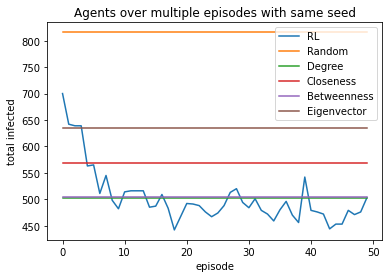

In [42]:
import numpy as np
import matplotlib.pyplot as plt
res = np.array([st[k]['average-overall-infected']['mean'] for k in eps])

plt.title('Agents over multiple episodes with same seed')
plt.xlabel('episode')
plt.ylabel('total infected')
plt.plot(range(len(eps)), res, label='RL')
plt.plot(range(len(eps)), [816] * len(eps), label='Random')
plt.plot(range(len(eps)), [503] * len(eps), label='Degree')
plt.plot(range(len(eps)), [568] * len(eps), label='Closeness')
plt.plot(range(len(eps)), [505] * len(eps), label='Betweenness')
plt.plot(range(len(eps)), [635] * len(eps), label='Eigenvector')
plt.legend()
plt.savefig('fig/rl_over_eps.pdf', format='pdf', bbox_inches='tight')

In [38]:
entries = []

In [ ]:
for i, entry in enumerate(entries):
    if entry['label'] == 'degree':
        entry.remove(i)

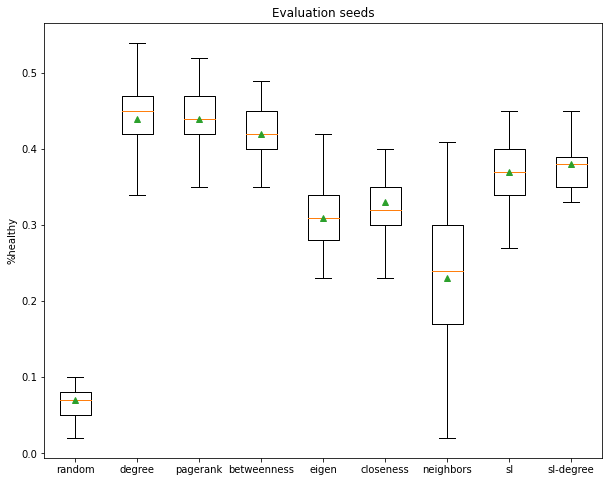

In [130]:
from lib.tracing.utils import pkl, get_pkl
import matplotlib.pyplot as plt

# res_dict = st['res']['average-%healthy']
# res_dict['label'] = 'sl-degree'
# entries.append(res_dict)
pkl(entries)

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Evaluation seeds')
ax.set_ylabel('%healthy')
f = ax.bxp(entries, showfliers=False, showmeans=True)
plt.savefig('fig/evaluation.pdf', format='pdf', bbox_inches='tight')

<h2> SL

In [50]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # sl + gnn (ranking)

%healthy:  0.37 ± 0.03


In [31]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # sl + gnn + degree (ranking)

%healthy:  0.37 ± 0.04


In [17]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # sl + gnn (just info)

%healthy:  0.34 ± 0.04


<h2> Random

In [38]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # random

%healthy:  0.09 ± 0.02


<h2> Neighbors/Counter

In [6]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # neighbors

%healthy:  0.28 ± 0.04


<h2> Centralities or other static measurements

In [36]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # clustering coefficient

%healthy:  0.11 ± 0.02


In [8]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # degree

%healthy:  0.4 ± 0.03


In [10]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # eigenvector

%healthy:  0.29 ± 0.03


In [43]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # betweenness centrality

%healthy:  0.39 ± 0.03


In [12]:
print('%healthy: ', st['res']['average-%healthy']['mean'], '±', st['res']['average-%healthy']['std']) # pagerank

%healthy:  0.4 ± 0.03


In [236]:
import lib.tracing.simulation as sim
rel(utils, sim, stat, network, agent, eng, run)
st = run.run_mock(agent=ag, control_after=0, nettype='barabasi', netsize=1000, k=10, isolate_s=False, first_inf=.1, presample=10000, pa=.2, \
                            p=.1, seed=11, trace_h=False, rem_orphans=True, taut=0, taut_two=-1, delay_two=4, model='seir', netseed=4, \
                            multip=multip, nnets=1, niters=1, dual=0, taur=0, noncomp=0, overlap_two=.7, noncomp_after=10000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=0, draw_iter=0, draw_layout='spring', sampling_type='min', nevents=0, trace_after=15,
                            summary_print=-1, summary_splits=100, r_window=7, avg_without_earlystop=True, spontan=False)

Running simulation with parameters:
netsize = 1000, k = 10, dual = 0, model = seir
overlap = 0.8, uptake = 0.5, maintain_overlap = False
taut = 0, taur = 0, noncomp = 0, noncomp_dependtime = True

----- Simulating network no. 0 -----
Running iteration 0:                                                                                                   
---> Result:973 total infected persons over time.                                                                      
Iterations simulation progress: 100%|████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.36s/it]


In [237]:
lst = [entry.time for entry in st[0][0][0][0]]
sorted(lst) == lst

True

In [67]:
def predict(model, net, nodes=None):
    x = torch.tensor(agent_inst.get_features(net, net_changed=True))
    edge_index = torch.tensor(list(net.to_directed().edges)).t().contiguous()
    try:
        model_predict = model.model
    except:
        model_predict = model
    model_predict.eval()
    with torch.no_grad():
        preds = model_predict(x, edge_index)
    return preds[0].detach().cpu().numpy()

In [ ]:
from pprint import pprint
import networkx as nx
true = extra[1]
true.init_states('S')
nid = list(range(10, 100, 10))
true.change_state(nid, 'I')
pprint(f'Degree centralities: {nx.degree_centrality(true)}')
print(f'Neighbors of infected node {nid}:')
# print(list(true.neighbors(nid)))
print()
res = predict(model, true, range(len(true) - 1))
pprint({nid: (true.node_infected[nid], res[nid].item()) for nid in true})